<a href="https://colab.research.google.com/github/tgwon/ai4ml/blob/main/project/baseline1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **대구 교통 사고 피해 예측 AI 경진대회 Baseline Code**

## **Fixed Random Seed**  

seed 값에 의해 동일한 코드를 사용해도 결과가 다를 수 있기에, 동일한 결과를 위해 seed 값을 고정시킵니다

In [325]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

## **데이터 불러오기 및 병합**  


In [326]:
train_df = pd.read_csv('drive/MyDrive/ai4ml/open/train.csv')
test_df = pd.read_csv('drive/MyDrive/ai4ml/open/test.csv')

In [327]:
# 도시, 구, 동 분류
# \S+ : 하나 이상의 공백이 아닌 문자
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_df['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_df['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

In [328]:
train_df.head()

,ID,사고일시,요일,기상상태,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,...,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO,도시,구,동
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,...,70세,중상,0,1,0,0,5,대구광역시,중구,대신동
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,...,61세,경상,0,0,1,0,3,대구광역시,달서구,감삼동
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,승용,...,38세,경상,0,0,1,0,3,대구광역시,수성구,두산동
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,...,36세,중상,0,1,0,0,5,대구광역시,북구,복현동
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,...,52세,경상,0,0,1,0,3,대구광역시,동구,신암동


In [329]:
test_df.head()

,ID,사고일시,요일,기상상태,도로형태,노면상태,사고유형,도시,구,동
0,ACCIDENT_39609,2022-01-01 01,토요일,맑음,교차로 - 교차로안,건조,차대사람,대구광역시,수성구,상동
1,ACCIDENT_39610,2022-01-01 01,토요일,맑음,단일로 - 기타,건조,차대사람,대구광역시,수성구,지산동
2,ACCIDENT_39611,2022-01-01 04,토요일,맑음,교차로 - 교차로안,건조,차대차,대구광역시,수성구,수성동2가
3,ACCIDENT_39612,2022-01-01 04,토요일,맑음,단일로 - 기타,건조,차대차,대구광역시,수성구,신매동
4,ACCIDENT_39613,2022-01-01 06,토요일,맑음,교차로 - 교차로안,건조,차대차,대구광역시,달서구,감삼동


In [330]:
cctv = pd.read_csv('/content/drive/MyDrive/ai4ml/open/external_open/대구 CCTV 정보.csv',encoding='cp949')
cctv.head()

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,소재지지번주소,위도,경도,설치장소,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도
0,주차12,대구광역시,남구,시도,NaN,대명로,3,대구광역시 남구 대명로 162,대구광역시 남구 대명동 903-13,35.838857,128.575418,안지랑네거리1 버스정류장,4,0,NaN,NaN,99.0,2010.0
1,주차13,대구광역시,남구,시도,NaN,봉덕로,3,대구광역시 남구 봉덕로 135,대구광역시 남구 봉덕동 853-8,35.844653,128.604619,효성백년가약,4,0,NaN,NaN,99.0,2013.0
2,주차14,대구광역시,남구,시도,NaN,대봉로,3,대구광역시 남구 봉덕로 134,대구광역시 남구 봉덕동 866-46,35.844183,128.604815,강변코오롱하늘채,4,0,NaN,NaN,99.0,2013.0
3,주차15,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 200,대구광역시 남구 대명동 2680-17,35.834798,128.585284,보성청록타운,4,0,NaN,NaN,99.0,2014.0
4,주차16,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 243,대구광역시 남구 봉덕동 1616,35.832728,128.588324,환경차고지,4,0,NaN,NaN,99.0,2014.0


In [331]:
cctv.shape

(1065, 18)

In [332]:
cctv.소재지지번주소.nunique()

918

In [333]:
cctv['cctv설치개수'] = 1

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
cctv[['도시', '구', '동', '번지']] = cctv['소재지지번주소'].str.extract(location_pattern)
cctv = cctv[['cctv설치개수','도시','구','동']]

cctv = cctv.groupby([ '구', '동']).sum().reset_index()
cctv['도시'] = '대구광역시'
cctv.reset_index(inplace=True, drop=True)

cctv.head()

<ipython-input-333-30990438bb90>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cctv = cctv.groupby([ '구', '동']).sum().reset_index()


,구,동,cctv설치개수,도시
0,가창면,삼산리,1,대구광역시
1,군위군,군위읍,3,대구광역시
2,군위군,부계면,4,대구광역시
3,군위군,삼국유사면,1,대구광역시
4,군위군,소보면,3,대구광역시


In [334]:
boan = pd.read_csv('/content/drive/MyDrive/ai4ml/open/external_open/대구 보안등 정보.csv',encoding='cp949')
boan.head()

<ipython-input-334-7dac1b63dfa5>:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  boan = pd.read_csv('/content/drive/MyDrive/ai4ml/open/external_open/대구 보안등 정보.csv',encoding='cp949')


,보안등위치명,설치개수,소재지도로명주소,소재지지번주소,위도,경도,설치연도,설치형태
0,대명1동1,1,대구광역시 남구 현충로 155,대구광역시 남구 대명동 1722-4,35.846703,128.579803,2016.0,한전주
1,대명1동2,1,대구광역시 남구 현충로31길 10-1,대구광역시 남구 대명동 1723-11,35.846863,128.579406,2016.0,한전주
2,대명1동3,1,대구광역시 남구 현충로31길 9-8,대구광역시 남구 대명동 1722-56,35.846341,128.579342,2017.0,건축물
3,대명1동4,2,대구광역시 남구 현충로31길 19-11,대구광역시 남구 대명동 1722-41,35.846368,128.578922,2016.0,한전주
4,대명1동5,1,대구광역시 남구 현충로29길 22-2,대구광역시 남구 대명동 1721-22,35.845995,128.578858,2016.0,한전주


In [335]:
boan.shape

(71913, 8)

In [336]:
boan.소재지지번주소.nunique()

63217

In [337]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

boan[['도시', '구', '동', '번지']] = boan['소재지지번주소'].str.extract(location_pattern)
boan = boan.drop(columns=['소재지지번주소', '번지', '위도', '경도', '설치연도'])

boan = boan.groupby(['도시', '구', '동']).sum().reset_index()
boan.reset_index(inplace=True, drop=True)

boan = boan.rename(columns={'설치개수': '보안등설치개수'})

boan.head()

<ipython-input-337-d4c6a40d4a2b>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  boan = boan.groupby(['도시', '구', '동']).sum().reset_index()


,도시,구,동,보안등설치개수
0,대구광역시,남구,대명동,5377
1,대구광역시,남구,봉덕동,1424
2,대구광역시,남구,이천동,556
3,대구광역시,달서구,갈산동,349
4,대구광역시,달서구,감삼동,932


In [338]:
child = pd.read_csv('/content/drive/MyDrive/ai4ml/open/external_open/대구 어린이 보호 구역 정보.csv',encoding='cp949')
child.head()

,시설종류,대상시설명,소재지도로명주소,소재지지번주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자
0,초등학교,남도초등학교,대구광역시 남구 현충동길 74(대명동),대구광역시 남구 대명동 1709,35.845027,128.581402,대구광역시,남부경찰서,Y,7.0,6~8,2020-03-23
1,초등학교,영선초등학교,대구광역시 남구 영선길96(이천동),대구광역시 남구 이천동 477,35.852901,128.596014,대구광역시,남부경찰서,Y,8.0,6~10,2020-03-23
2,초등학교,성명초등학교,대구광역시 남구 성당로 30길 55(대명동),대구광역시 남구 대명동 3050,35.845152,128.570825,대구광역시,남부경찰서,Y,14.0,8~12,2020-03-23
3,초등학교,남덕초등학교,대구광역시 남구 앞산순환로 93길 33,대구광역시 남구 대명동 531-1,35.833042,128.573949,대구광역시,남부경찰서,Y,6.0,6~8,2020-03-23
4,초등학교,대명초등학교,대구광역시 남구 대명로 110,대구광역시 남구 대명동 960,35.838869,128.568889,대구광역시,남부경찰서,Y,5.0,6~10,2020-03-23


In [339]:
child['어린이보호구역CCTV설치구역수'] = 1

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

child[['도시', '구', '동', '번지']] = child['소재지지번주소'].str.extract(location_pattern)
child = child.drop(columns=['소재지지번주소', '번지', '위도', '경도'])

child = child.groupby(['도시', '구', '동']).sum().reset_index()
child.reset_index(inplace=True, drop=True)

# 둘 중 뭐 쓸까? 나눠서 쓸까?
child = child.rename(columns={'CCTV설치대수': '어린이보호구역CCTV설치개수'})

child.head()

<ipython-input-339-5d69571ee811>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  child = child.groupby(['도시', '구', '동']).sum().reset_index()


,도시,구,동,어린이보호구역CCTV설치개수,어린이보호구역CCTV설치구역수
0,대구광역시,남구,대명동,106.0,26
1,대구광역시,남구,봉덕동,34.0,8
2,대구광역시,남구,이천동,22.0,6
3,대구광역시,달성군,가창면,0.0,8
4,대구광역시,달성군,구지면,4.0,6


In [340]:
park = pd.read_csv('/content/drive/MyDrive/ai4ml/open/external_open/대구 주차장 정보.csv',encoding='cp949')
park.head()

,주차장관리번호,주차장명,주차장구분,주차장유형,소재지도로명주소,소재지지번주소,주차구획수,급지구분,부제시행구분,운영요일,...,추가단위시간,추가단위요금,1일주차권요금적용시간,1일주차권요금,월정기권요금,결제방법,특기사항,위도,경도,데이터기준일자
0,153-2-000001,봉덕공영주차장,공영,노외,대구광역시 남구 중앙대로22길 199,대구광역시 남구 봉덕동 1002-69,62,1,미시행,평일+토요일+공휴일,...,10.0,200.0,210.0,4000.0,70000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.842206,128.601725,2020-01-01
1,153-2-000002,봉삼공영주차장,공영,노외,NaN,대구광역시 남구 봉덕동 687-8,36,1,미시행,평일+토요일+공휴일,...,10.0,200.0,210.0,4000.0,70000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.842811,128.597209,2020-01-01
2,153-2-000003,대명2동공영주차장,공영,노외,대구광역시 남구 중앙대로45길 57,대구광역시 남구 대명동 1803-10,31,1,미시행,평일+토요일+공휴일,...,10.0,200.0,210.0,4000.0,40000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.855011,128.589359,2020-01-01
3,153-2-000004,고산골공영주차장,공영,노외,대구광역시 남구 용두2길 43,대구광역시 남구 봉덕동 1256,88,2,미시행,평일+토요일+공휴일,...,10.0,100.0,210.0,2000.0,20000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.830066,128.603443,2020-01-01
4,153-2-000005,봉덕시장공영주차장,공영,노외,대구광역시 남구 봉덕로25길 6,대구광역시 남구 봉덕동 976-5,32,1,미시행,평일+토요일+공휴일,...,10.0,200.0,160.0,3000.0,70000.0,현금,"경차,장애인차량,국가유공자차량,승용차요일제차량,저공해차량, 환경친화적 자동차 50 할인.",35.844925,128.602667,2020-01-01


In [341]:
park.columns

Index(['주차장관리번호', '주차장명', '주차장구분', '주차장유형', '소재지도로명주소', '소재지지번주소', '주차구획수',
       '급지구분', '부제시행구분', '운영요일', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각',
       '토요일운영종료시각', '공휴일운영시작시각', '공휴일운영종료시각', '요금정보', '주차기본시간', '주차기본요금',
       '추가단위시간', '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금', '결제방법', '특기사항',
       '위도', '경도', '데이터기준일자'],
      dtype='object')

In [342]:
park['운영요일'].value_counts()

평일+토요일+공휴일    677
평일+토요일        173
평일             21
Name: 운영요일, dtype: int64

In [343]:
park = park[['소재지지번주소', '급지구분']]
park = pd.get_dummies(park, columns=['급지구분'])
park['주차장개수'] = 1

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

park[['도시', '구', '동', '번지']] = park['소재지지번주소'].str.extract(location_pattern)
parking_df = park.drop(columns=['소재지지번주소', '번지'])

park = park.groupby(['도시', '구', '동']).sum().reset_index()
park.reset_index(inplace=True, drop=True)

park = park.rename(columns={'급지구분_1': '1주차장개수'})
park = park.rename(columns={'급지구분_2': '2주차장개수'})
park = park.rename(columns={'급지구분_3': '3주차장개수'})

park.head()

# 급지구분1/2/3: 동별 급지별 주차장 개수
# 동별 주차장 구획수 vs 동별 급지별 주차장 개수 중에 뭘 하면 좋을까요
# 운영 요일(주말 운영 여부)도 고려하면 조을듯

<ipython-input-343-9ca175508a92>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  park = park.groupby(['도시', '구', '동']).sum().reset_index()


,도시,구,동,1주차장개수,2주차장개수,3주차장개수,주차장개수
0,대구광역시,남구,대명동,20,1,0,21
1,대구광역시,남구,봉덕동,9,3,0,12
2,대구광역시,남구,이천동,3,0,0,3
3,대구광역시,달서구,갈산동,0,0,4,4
4,대구광역시,달서구,감삼동,0,1,3,4


In [344]:
train_df = pd.merge(train_df, park, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, child, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, boan, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, cctv, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, park, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, child, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, boan, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, cctv, how='left', on=['도시', '구', '동'])

In [345]:
train_df.head()

,ID,사고일시,요일,기상상태,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,...,구,동,1주차장개수,2주차장개수,3주차장개수,주차장개수,어린이보호구역CCTV설치개수,어린이보호구역CCTV설치구역수,보안등설치개수,cctv설치개수
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,...,중구,대신동,11.0,0.0,0.0,11.0,13.0,2.0,391.0,5.0
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,...,달서구,감삼동,0.0,1.0,3.0,4.0,NaN,NaN,932.0,12.0
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,승용,...,수성구,두산동,NaN,NaN,NaN,NaN,0.0,5.0,473.0,4.0
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,...,북구,복현동,0.0,9.0,5.0,14.0,32.0,11.0,534.0,10.0
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,...,동구,신암동,0.0,1.0,0.0,1.0,NaN,NaN,2057.0,12.0


In [346]:
test_df.head()

,ID,사고일시,요일,기상상태,도로형태,노면상태,사고유형,도시,구,동,1주차장개수,2주차장개수,3주차장개수,주차장개수,어린이보호구역CCTV설치개수,어린이보호구역CCTV설치구역수,보안등설치개수,cctv설치개수
0,ACCIDENT_39609,2022-01-01 01,토요일,맑음,교차로 - 교차로안,건조,차대사람,대구광역시,수성구,상동,NaN,NaN,NaN,NaN,0.0,5.0,700.0,4.0
1,ACCIDENT_39610,2022-01-01 01,토요일,맑음,단일로 - 기타,건조,차대사람,대구광역시,수성구,지산동,0.0,0.0,2.0,2.0,0.0,10.0,NaN,7.0
2,ACCIDENT_39611,2022-01-01 04,토요일,맑음,교차로 - 교차로안,건조,차대차,대구광역시,수성구,수성동2가,NaN,NaN,NaN,NaN,0.0,1.0,NaN,1.0
3,ACCIDENT_39612,2022-01-01 04,토요일,맑음,단일로 - 기타,건조,차대차,대구광역시,수성구,신매동,0.0,2.0,1.0,3.0,0.0,7.0,NaN,11.0
4,ACCIDENT_39613,2022-01-01 06,토요일,맑음,교차로 - 교차로안,건조,차대차,대구광역시,달서구,감삼동,0.0,1.0,3.0,4.0,NaN,NaN,932.0,12.0


## **train, test 데이터 기간 확인하기**  

학습(train) 데이터의 기간과 예측 대상이 되는 test 데이터의 기간을 살펴 봅니다

In [347]:
print(f"train : {train_df.iloc[0]['사고일시']} ~ {train_df.iloc[-1]['사고일시']}")
print(f"test : {test_df.iloc[0]['사고일시']} ~ {test_df.iloc[-1]['사고일시']}")

train : 2019-01-01 00 ~ 2021-12-31 23
test : 2022-01-01 01 ~ 2022-12-31 21


## **예측 대상 확인하기**

sample_submission.csv를 로드하여 출력 형식을 확인해 봄으로서,
대회 페이지 규칙에 기술되어 있는, 예측 대상이 무엇인지 확인해 봅시다.

최종적으로 예측해야 하는 값은 'ECLO'(인명피해 심각도) 값입니다.

그러나, train데이터 컬럼에 있는 '사망자수', '중상자수', '경상자수', '부상자수'를 각각 예측하여 ECLO 예측값을 구할 수도 있습니다. 즉, ECLO 값을 예측하는 단일 모델로 접근할 수도,  각각을 별도로 예측하는 모델로 접근할 수도 있습니다.

<img src="https://drive.google.com/uc?id=19PvSqu8k04D3a-Bskcl-d-Xkckkn2Fvv">  

In [348]:
sample_submission = pd.read_csv("drive/MyDrive/ai4ml/open/sample_submission.csv")
sample_submission.head()

,ID,ECLO
0,ACCIDENT_39609,0
1,ACCIDENT_39610,0
2,ACCIDENT_39611,0
3,ACCIDENT_39612,0
4,ACCIDENT_39613,0


## **데이터 전처리**  

현재 '사고일시', '시군구', '도로형태' 컬럼은 반복되는 패턴으로 여러 정보를 포함하고 있습니다
이런 반복되는 패턴을 일반화하면 pandas에서 제공하는 str.extract를 통해 한 번에 추출 가능합니다  

## **파생 변수 생성 1 : 날짜, 시간정보 생성**

'사고일시' 컬럼으로 부터 연도, 월, 일, 시간 정보 추출 및 변환 합니다

In [349]:
train_df = train_df.copy()
test_df = test_df.copy()

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_df['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다

# 해당 과정을 test_x에 대해서도 반복해줍니다
test_df[['연', '월', '일', '시간']] = test_df['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

## **파생 변수 추출 2 : 도로 형태 정보 추출**  

'도로형태' 컬럼은 '단일로 - 기타'와 같은 패턴으로 구성되어 있습니다. 이를 두종류의 독립된 정보로 보고 두개의 컬럼으로 분리하여 생성합니다.

In [350]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_df['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_df['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

## **파생 변수 추출 3 : 주말 변수**  
#### 공휴일 하나하나 확인까지는 안함

In [351]:
train_df['주말'] = train_df['요일'].apply(lambda x: 1 if x in ['토요일', '일요일'] else 0)
train_df = train_df.drop(columns=['요일'])
test_df['주말'] = test_df['요일'].apply(lambda x: 1 if x in ['토요일', '일요일'] else 0)
test_df = test_df.drop(columns=['요일'])

## **파생 변수 추출 4 : 시간대 변수**

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packag

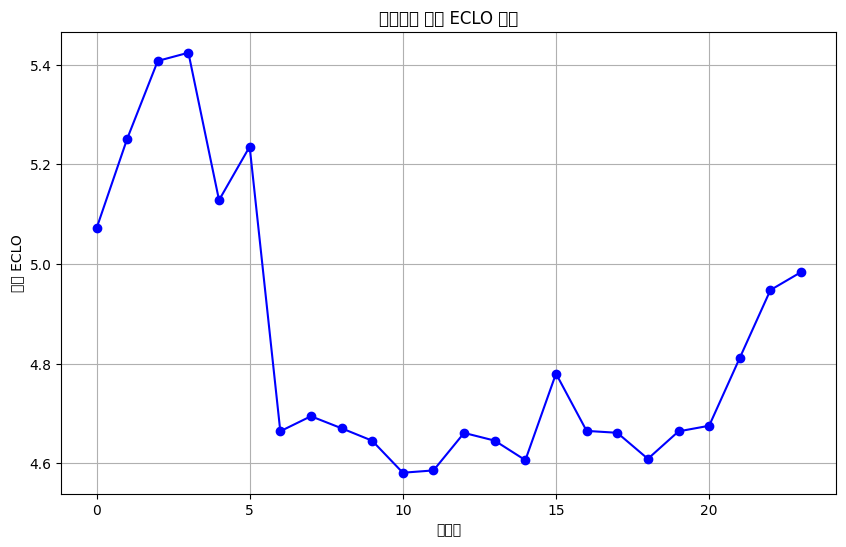

In [352]:
# 6~20 : 활동시간대
# 그 외 : 휴식시간대

train_df_avg = train_df.groupby('시간')['ECLO'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(train_df_avg['시간'], train_df_avg['ECLO'], marker='o', linestyle='-', color='b')
plt.title('시간대별 평균 ECLO 변화')
plt.xlabel('시간대')
plt.ylabel('평균 ECLO')
plt.grid(True)
plt.show()

In [353]:
train_df['시간'] = train_df['시간'].apply(lambda x: 1 if 6 <= x <= 20 else 0)
train_df = pd.get_dummies(train_df, columns=['시간'])
train_df = train_df.rename(columns={'시간_0': '휴식시간대'})
train_df = train_df.rename(columns={'시간_1': '활동시간대'})

In [354]:
test_df['시간'] = test_df['시간'].apply(lambda x: 1 if 6 <= x <= 20 else 0)
test_df = pd.get_dummies(test_df, columns=['시간'])
test_df = test_df.rename(columns={'시간_0': '휴식시간대'})
test_df = test_df.rename(columns={'시간_1': '활동시간대'})

## **전처리 결과 확인**

지금까지 전처리한 결과를 확인해 봅시다

In [355]:
train_df.head()

,ID,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,...,보안등설치개수,cctv설치개수,연,월,일,도로형태1,도로형태2,주말,휴식시간대,활동시간대
0,ACCIDENT_00000,맑음,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,상해없음,...,391.0,5.0,2019,1,1,단일로,기타,0,1,0
1,ACCIDENT_00001,흐림,건조,차대사람,보도통행중,기타,승용,남,39세,상해없음,...,932.0,12.0,2019,1,1,단일로,기타,0,1,0
2,ACCIDENT_00002,맑음,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,상해없음,...,473.0,4.0,2019,1,1,단일로,기타,0,1,0
3,ACCIDENT_00003,맑음,건조,차대차,추돌,안전운전불이행,승용,남,49세,상해없음,...,534.0,10.0,2019,1,1,단일로,기타,0,1,0
4,ACCIDENT_00004,맑음,건조,차대차,추돌,안전운전불이행,승용,남,30세,상해없음,...,2057.0,12.0,2019,1,1,단일로,기타,0,1,0


In [356]:
train_df.columns

Index(['ID', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',
       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',
       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '도시',
       '구', '동', '1주차장개수', '2주차장개수', '3주차장개수', '주차장개수', '어린이보호구역CCTV설치개수',
       '어린이보호구역CCTV설치구역수', '보안등설치개수', 'cctv설치개수', '연', '월', '일', '도로형태1',
       '도로형태2', '주말', '휴식시간대', '활동시간대'],
      dtype='object')

In [357]:
test_df.head()

,ID,기상상태,노면상태,사고유형,도시,구,동,1주차장개수,2주차장개수,3주차장개수,...,보안등설치개수,cctv설치개수,연,월,일,도로형태1,도로형태2,주말,휴식시간대,활동시간대
0,ACCIDENT_39609,맑음,건조,차대사람,대구광역시,수성구,상동,NaN,NaN,NaN,...,700.0,4.0,2022,1,1,교차로,교차로안,1,1,0
1,ACCIDENT_39610,맑음,건조,차대사람,대구광역시,수성구,지산동,0.0,0.0,2.0,...,NaN,7.0,2022,1,1,단일로,기타,1,1,0
2,ACCIDENT_39611,맑음,건조,차대차,대구광역시,수성구,수성동2가,NaN,NaN,NaN,...,NaN,1.0,2022,1,1,교차로,교차로안,1,1,0
3,ACCIDENT_39612,맑음,건조,차대차,대구광역시,수성구,신매동,0.0,2.0,1.0,...,NaN,11.0,2022,1,1,단일로,기타,1,1,0
4,ACCIDENT_39613,맑음,건조,차대차,대구광역시,달서구,감삼동,0.0,1.0,3.0,...,932.0,12.0,2022,1,1,교차로,교차로안,1,0,1


In [358]:
test_df.columns

Index(['ID', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '1주차장개수', '2주차장개수',
       '3주차장개수', '주차장개수', '어린이보호구역CCTV설치개수', '어린이보호구역CCTV설치구역수', '보안등설치개수',
       'cctv설치개수', '연', '월', '일', '도로형태1', '도로형태2', '주말', '휴식시간대', '활동시간대'],
      dtype='object')

## **train, test 데이터의 독립변수, 종속 변수 분리, 최종 데이터셋 확정**

모델 추론 시점에서 획득할 수 있는 데이터는 학습 시점에서 활용할 수 있는 데이터와 다를 수 있습니다  
그렇기에 본 baseline에서는 test 시점에서만 활용할 수 있는 데이터들(test의 column들)만 사용하여 train 데이터를 구성했습니다

train_df 중에서 test_x가 가진 column들만 추출하여 train_x(독립변수)를 구성하고, train_df 중에서 예측 목표인 EPDO를 추출하여 train_y(종속변수)를 구성합니다

In [359]:
test_x = test_df.drop(columns=['ID']).copy()
train_x = train_df[test_x.columns].copy()
train_y = train_df['ECLO'].copy()

In [360]:
train_x.isnull().sum()

기상상태                    0
노면상태                    0
사고유형                    0
도시                      0
구                       0
동                       0
1주차장개수               6543
2주차장개수               6543
3주차장개수               6543
주차장개수                6543
어린이보호구역CCTV설치개수     18426
어린이보호구역CCTV설치구역수    18426
보안등설치개수              9513
cctv설치개수             1576
연                       0
월                       0
일                       0
도로형태1                   0
도로형태2                   0
주말                      0
휴식시간대                   0
활동시간대                   0
dtype: int64

In [361]:
test_x.isnull().sum()

기상상태                   0
노면상태                   0
사고유형                   0
도시                     0
구                      0
동                      0
1주차장개수              1928
2주차장개수              1928
3주차장개수              1928
주차장개수               1928
어린이보호구역CCTV설치개수     4961
어린이보호구역CCTV설치구역수    4961
보안등설치개수             2771
cctv설치개수             455
연                      0
월                      0
일                      0
도로형태1                  0
도로형태2                  0
주말                     0
휴식시간대                  0
활동시간대                  0
dtype: int64

In [362]:
train_x.fillna(0, inplace=True)
test_x.fillna(0, inplace=True)

In [365]:
train_x = train_x.drop(columns=['도시','구','연'])
test_x = test_x.drop(columns=['도시','구','연'])

In [366]:
train_x.shape, train_y.shape, test_x.shape

((39609, 19), (39609,), (10963, 19))

In [367]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   기상상태              39609 non-null  object 
 1   노면상태              39609 non-null  object 
 2   사고유형              39609 non-null  object 
 3   동                 39609 non-null  object 
 4   1주차장개수            39609 non-null  float64
 5   2주차장개수            39609 non-null  float64
 6   3주차장개수            39609 non-null  float64
 7   주차장개수             39609 non-null  float64
 8   어린이보호구역CCTV설치개수   39609 non-null  float64
 9   어린이보호구역CCTV설치구역수  39609 non-null  float64
 10  보안등설치개수           39609 non-null  float64
 11  cctv설치개수          39609 non-null  float64
 12  월                 39609 non-null  int64  
 13  일                 39609 non-null  int64  
 14  도로형태1             39609 non-null  object 
 15  도로형태2             39609 non-null  object 
 16  주말                39609 non-null  int64 

In [368]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10963 entries, 0 to 10962
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   기상상태              10963 non-null  object 
 1   노면상태              10963 non-null  object 
 2   사고유형              10963 non-null  object 
 3   동                 10963 non-null  object 
 4   1주차장개수            10963 non-null  float64
 5   2주차장개수            10963 non-null  float64
 6   3주차장개수            10963 non-null  float64
 7   주차장개수             10963 non-null  float64
 8   어린이보호구역CCTV설치개수   10963 non-null  float64
 9   어린이보호구역CCTV설치구역수  10963 non-null  float64
 10  보안등설치개수           10963 non-null  float64
 11  cctv설치개수          10963 non-null  float64
 12  월                 10963 non-null  int64  
 13  일                 10963 non-null  int64  
 14  도로형태1             10963 non-null  object 
 15  도로형태2             10963 non-null  object 
 16  주말                10963 non-null  int64 

## **범주형(Categorical) 변수, 수치형 변수로 변환하기**

모델 학습을 위해 train_x의 문자열 타입의 컬럼들을 추출하고, LabelEncoder를 활용하여 이 컬럼들을 모두 수치형 변수로 변환해 보겠습니다

In [375]:
from sklearn.preprocessing import LabelEncoder

categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(train_x[i])
    train_x[i]=le.transform(train_x[i])

    for case in np.unique(test_x[i]):
        if case not in le.classes_:
            le.classes_ = np.append(le.classes_, case)
    test_x[i]=le.transform(test_x[i])

display(train_x.head())
display(test_x.head())

['기상상태', '노면상태', '사고유형', '동', '도로형태1', '도로형태2']

,기상상태,노면상태,사고유형,동,1주차장개수,2주차장개수,3주차장개수,주차장개수,어린이보호구역CCTV설치개수,어린이보호구역CCTV설치구역수,보안등설치개수,cctv설치개수,월,일,도로형태1,도로형태2,주말,휴식시간대,활동시간대
0,2,0,0,40,11.0,0.0,0.0,11.0,13.0,2.0,391.0,5.0,1,1,2,5,0,1,0
1,5,0,0,4,0.0,1.0,3.0,4.0,0.0,0.0,932.0,12.0,1,1,2,5,0,1,0
2,2,0,0,66,0.0,0.0,0.0,0.0,0.0,5.0,473.0,4.0,1,1,2,5,0,1,0
3,2,0,1,79,0.0,9.0,5.0,14.0,32.0,11.0,534.0,10.0,1,1,2,5,0,1,0
4,2,0,1,129,0.0,1.0,0.0,1.0,0.0,0.0,2057.0,12.0,1,1,2,5,0,1,0


,기상상태,노면상태,사고유형,동,1주차장개수,2주차장개수,3주차장개수,주차장개수,어린이보호구역CCTV설치개수,어린이보호구역CCTV설치구역수,보안등설치개수,cctv설치개수,월,일,도로형태1,도로형태2,주말,휴식시간대,활동시간대
0,2,0,0,99,0.0,0.0,0.0,0.0,0.0,5.0,700.0,4.0,1,1,0,3,1,1,0
1,2,0,0,168,0.0,0.0,2.0,2.0,0.0,10.0,0.0,7.0,1,1,2,5,1,1,0
2,2,0,1,117,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,1,0,3,1,1,0
3,2,0,1,126,0.0,2.0,1.0,3.0,0.0,7.0,0.0,11.0,1,1,2,5,1,1,0
4,2,0,1,4,0.0,1.0,3.0,4.0,0.0,0.0,932.0,12.0,1,1,0,3,1,0,1


In [279]:
train_y.head()

0    5
1    3
2    3
3    5
4    3
Name: ECLO, dtype: int64

## **Model Train & Prediction**

전체 학습 데이터에 대하여 학습후 최종 예측을 합니다. 여기서는 DecisionTreeRegressor 모델로 학습하고 예측하는 예시 코드입니다.

In [286]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(train_x, train_y , test_size=0.2, random_state=0)
X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

((31687, 19), (7922, 19), (31687,), (7922,))

In [287]:
from sklearn.metrics import mean_squared_log_error
def rmsle(y_true,y_pred):
    return mean_squared_log_error(y_true,y_pred) ** 0.5

In [369]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
xr = XGBRegressor()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(estimator=xr, param_grid=param_grid, cv=5)

# 그리드 서치를 사용하여 최적의 하이퍼파라미터 선택하기
grid_search.fit(X_tr, y_tr)

# 최적의 하이퍼파라미터 출력하기
print(grid_search.best_params_)

# 최적의 모델로 예측 수행하기
pred = grid_search.predict(X_val)

rmsle(y_val,pred)

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}


0.4604588090041005

In [376]:
xr = XGBRegressor()
xr.fit(train_x, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [377]:
feature_importance = pd.DataFrame(xr.feature_importances_.reshape((1, -1)), columns=X_tr.columns, index=['feature_importance'])
feature_importance

,기상상태,노면상태,사고유형,동,1주차장개수,2주차장개수,3주차장개수,주차장개수,어린이보호구역CCTV설치개수,어린이보호구역CCTV설치구역수,보안등설치개수,cctv설치개수,월,일,도로형태1,도로형태2,주말,휴식시간대,활동시간대
feature_importance,0.056717,0.054062,0.140241,0.0442,0.042562,0.048401,0.073934,0.050245,0.04589,0.045375,0.047858,0.049537,0.038842,0.045532,0.03924,0.045788,0.070464,0.061113,0.0


In [381]:
train_x = train_x.drop(columns=['활동시간대','도로형태1','월','일'])
test_x = test_x.drop(columns=['활동시간대','도로형태1','월','일'])

In [382]:
# XGBoostRegressor 모델 정의
xgb_model = XGBRegressor()

# 튜닝할 하이퍼파라미터 값들 지정
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Grid Search 정의
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_log_error', cv=5)

# Grid Search 수행
grid_result = grid_search.fit(train_x, train_y)

# 최적의 하이퍼파라미터 출력
print("Best Parameters: ", grid_result.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py", line 525, in mean_squared_log_error
    raise ValueError(
ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_select

KeyboardInterrupt: ignored

In [ ]:
# 최적의 모델로 예측 수행하기
pred = grid_result.predict(test_x)

## **Submission 양식 확인**

sample_submission.csv 화일 데이터(sample_submission)를 그대로 복사한 후,
양식의 'ECLO' 컬럼에 test_x에 대한 ECLO(y) 예측값을 입력합니다

In [284]:
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = pred
baseline_submission

,ID,ECLO
0,ACCIDENT_39609,4.416297
1,ACCIDENT_39610,3.916275
2,ACCIDENT_39611,6.013711
3,ACCIDENT_39612,5.359249
4,ACCIDENT_39613,5.090872
...,...,...
10958,ACCIDENT_50567,7.185309
10959,ACCIDENT_50568,5.251634
10960,ACCIDENT_50569,5.432641
10961,ACCIDENT_50570,5.221332


## **답안지 저장 및 제출하기**

In [285]:
# 제출하고 싶을 때 마다 파일명 뒤에 숫자를 바꿔주세요!
baseline_submission.to_csv('drive/MyDrive/ai4ml/open/submit3.csv', index=False)